### 0. Setup

In [28]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
from features import *

import time
from moviepy.editor import VideoFileClip
from collections import deque
from skimage.feature import hog
import cv2
from glob import glob
import numpy as np
from IPython.display import HTML

from SVCClassifier import *
from VehicleDetector import *

from utilities import *
%load_ext autoreload
%autoreload 2
%matplotlib inline 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0. Setup - Test data set

In [2]:
car_image_files = glob("./sample_data/test_images_car/*")
car_images = []
for fname in car_image_files:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    car_images.append(img)

not_car_image_files = glob("sample_data/test_images_not_car/*")
not_car_images = []
for fname in not_car_image_files:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    not_car_images.append(img)


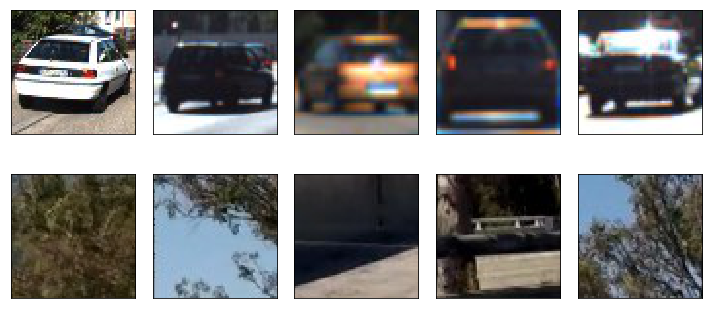

In [3]:
import random

cars = random.sample(car_images,5)
not_cars = random.sample(not_car_images,5)

# Look at few images
f, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
cars_ax = axes[0]
not_cars_ax = axes[1]

for i in range(0,5):
    cars_ax[i].imshow(cars[i])
    not_cars_ax[i].imshow(not_cars[i])

plt.tight_layout()



### 1. Feature extraction

#### 1. a. Feature extraction - HOG

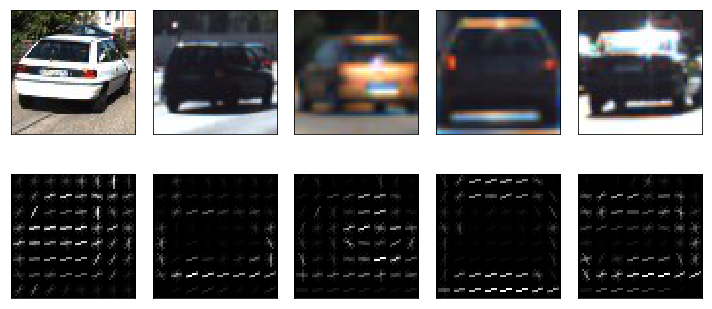

In [4]:
# Look at few images
f, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
cars_ax = axes[0]
not_cars_ax = axes[1]

for i in range(0,5):
    f, vis = hog(cv2.cvtColor(cars[i],cv2.COLOR_RGB2GRAY), 9, pixels_per_cell = (8,8), cells_per_block = (2,2), visualise=True, feature_vector=True)
    cars_ax[i].imshow(cars[i])
    not_cars_ax[i].imshow(vis, cmap = 'gray')
    
plt.tight_layout()


#### 1. b. Feature extraction - Color

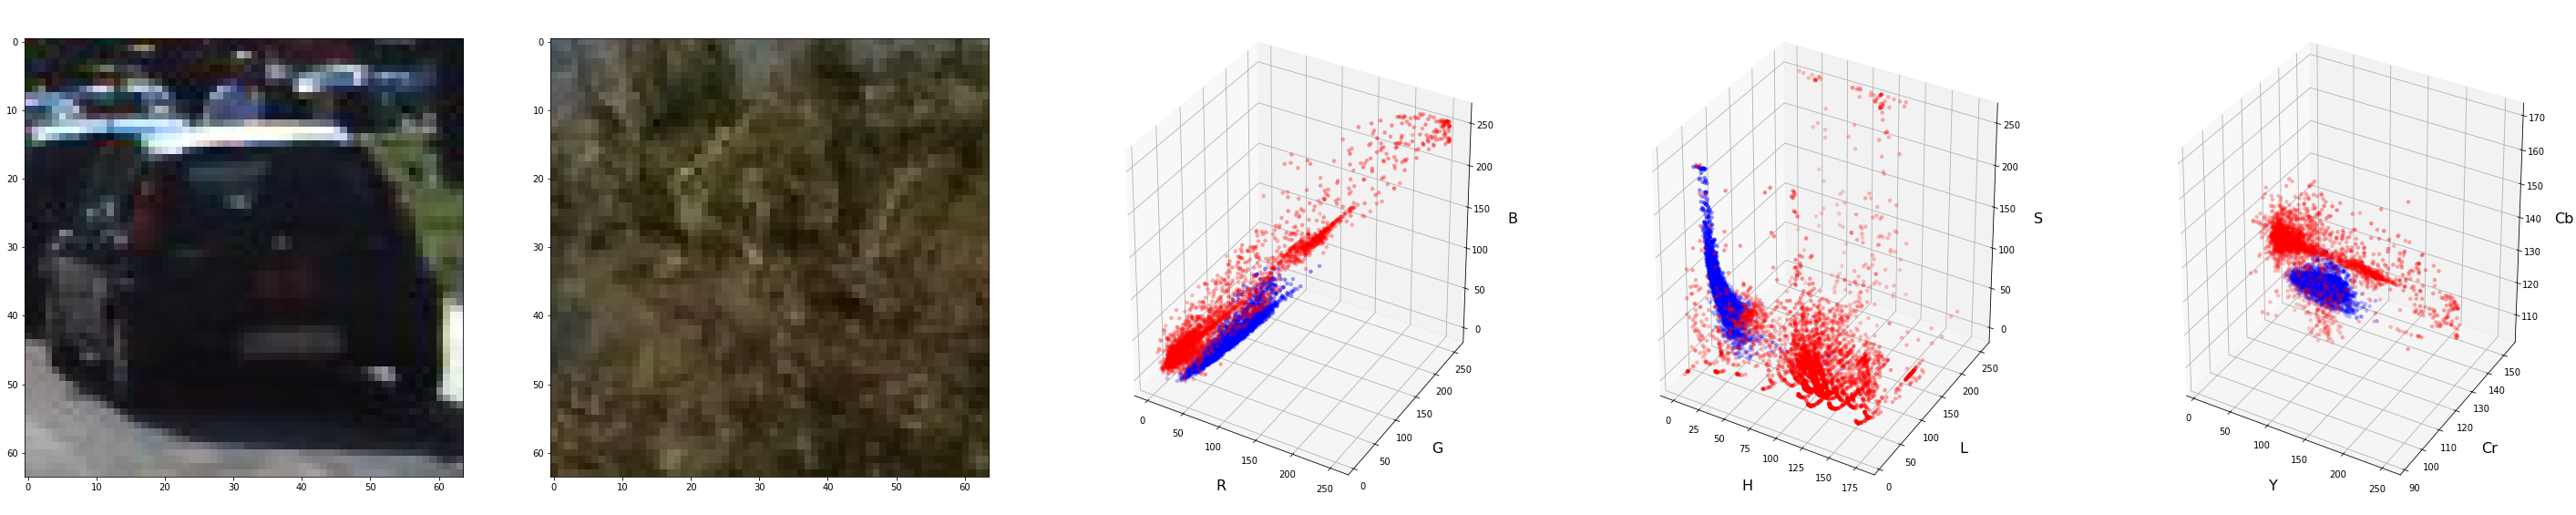

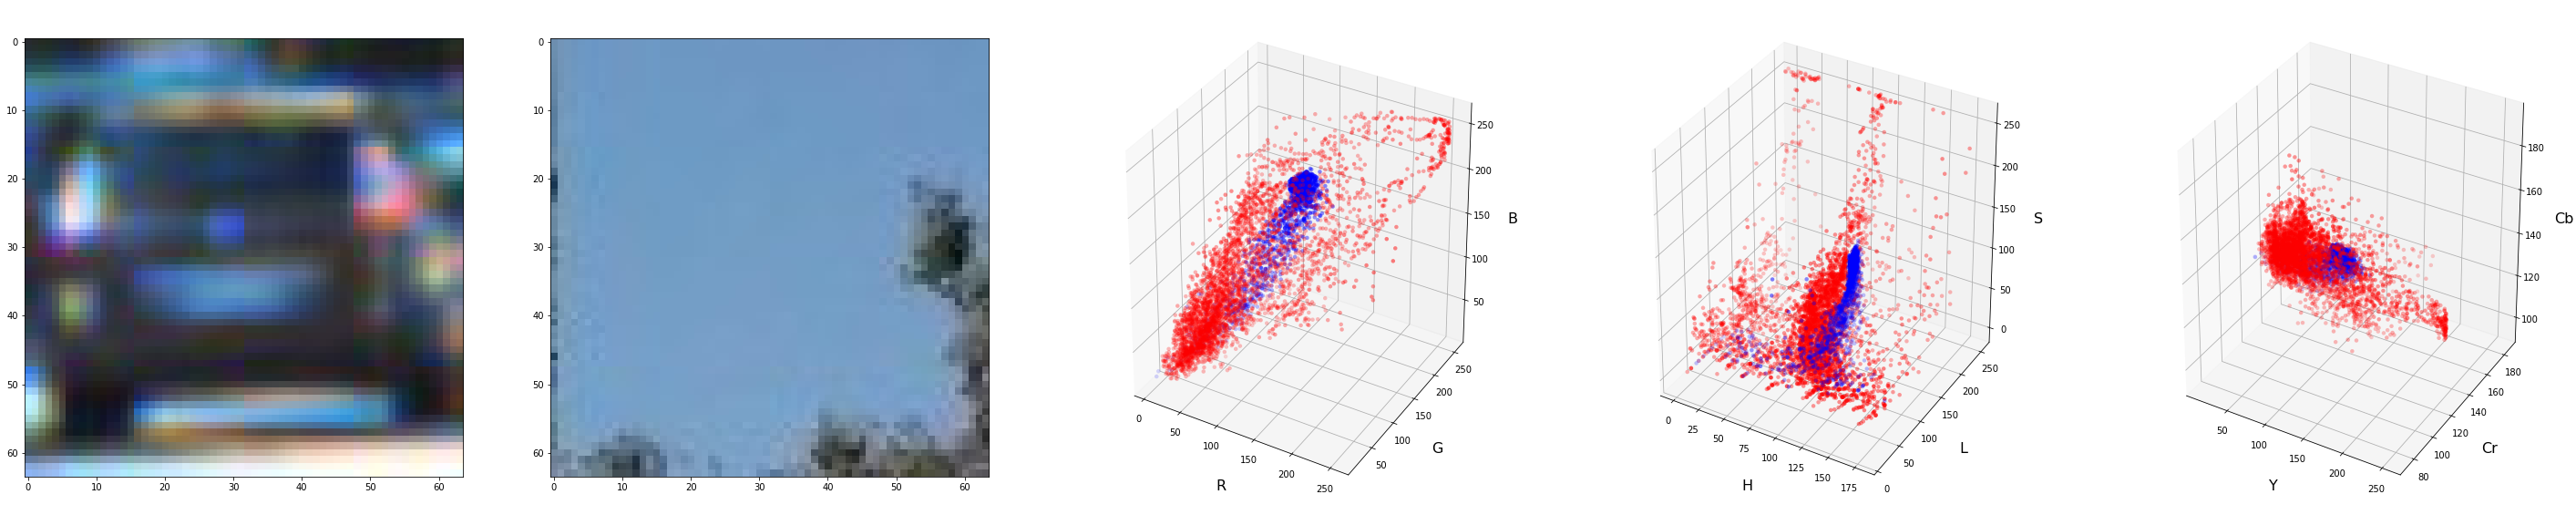

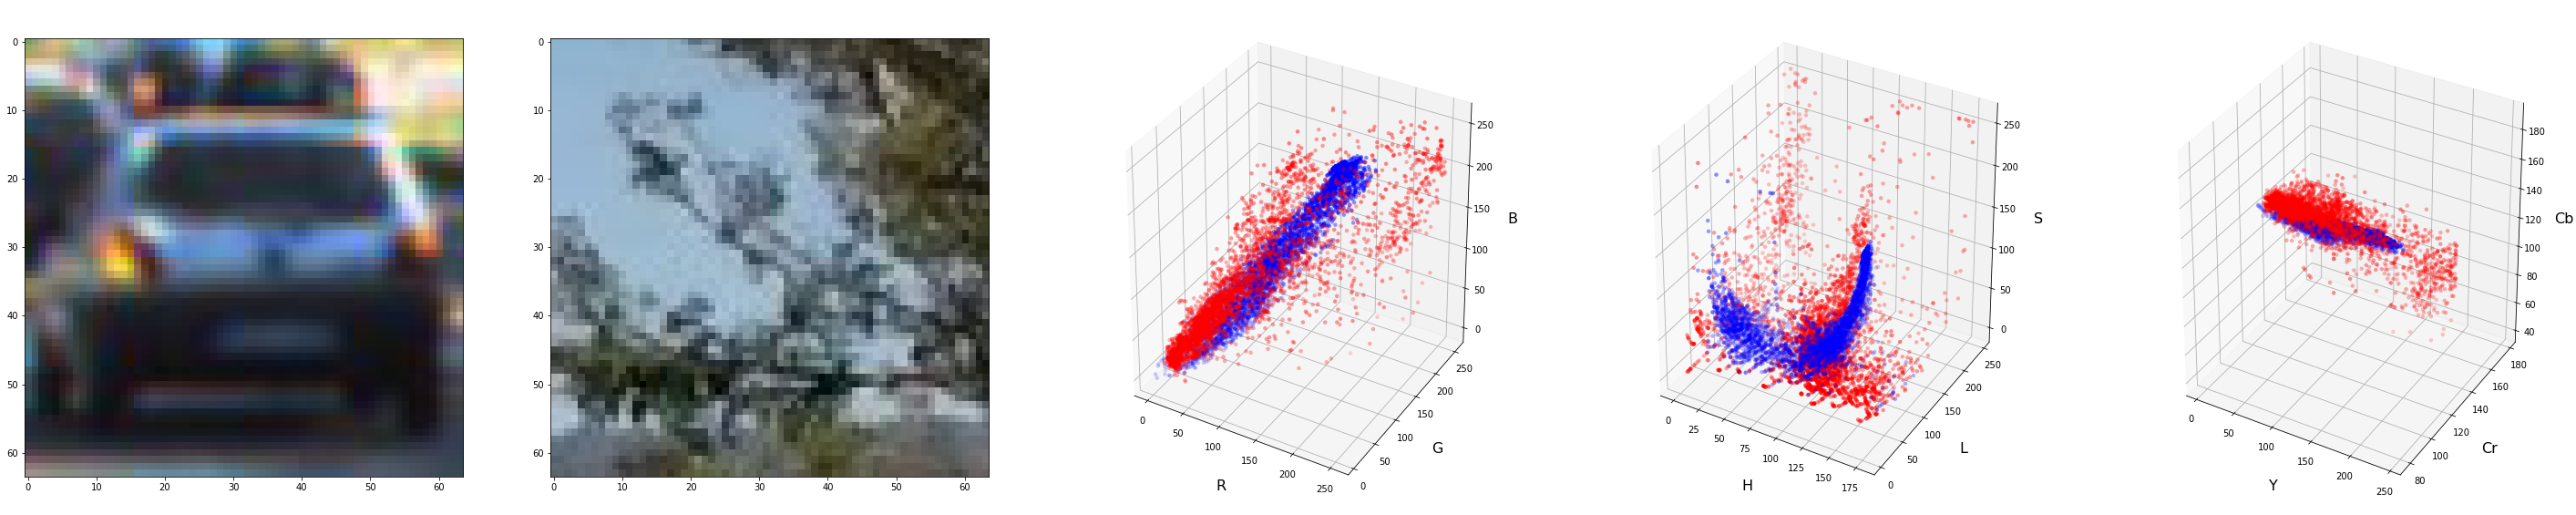

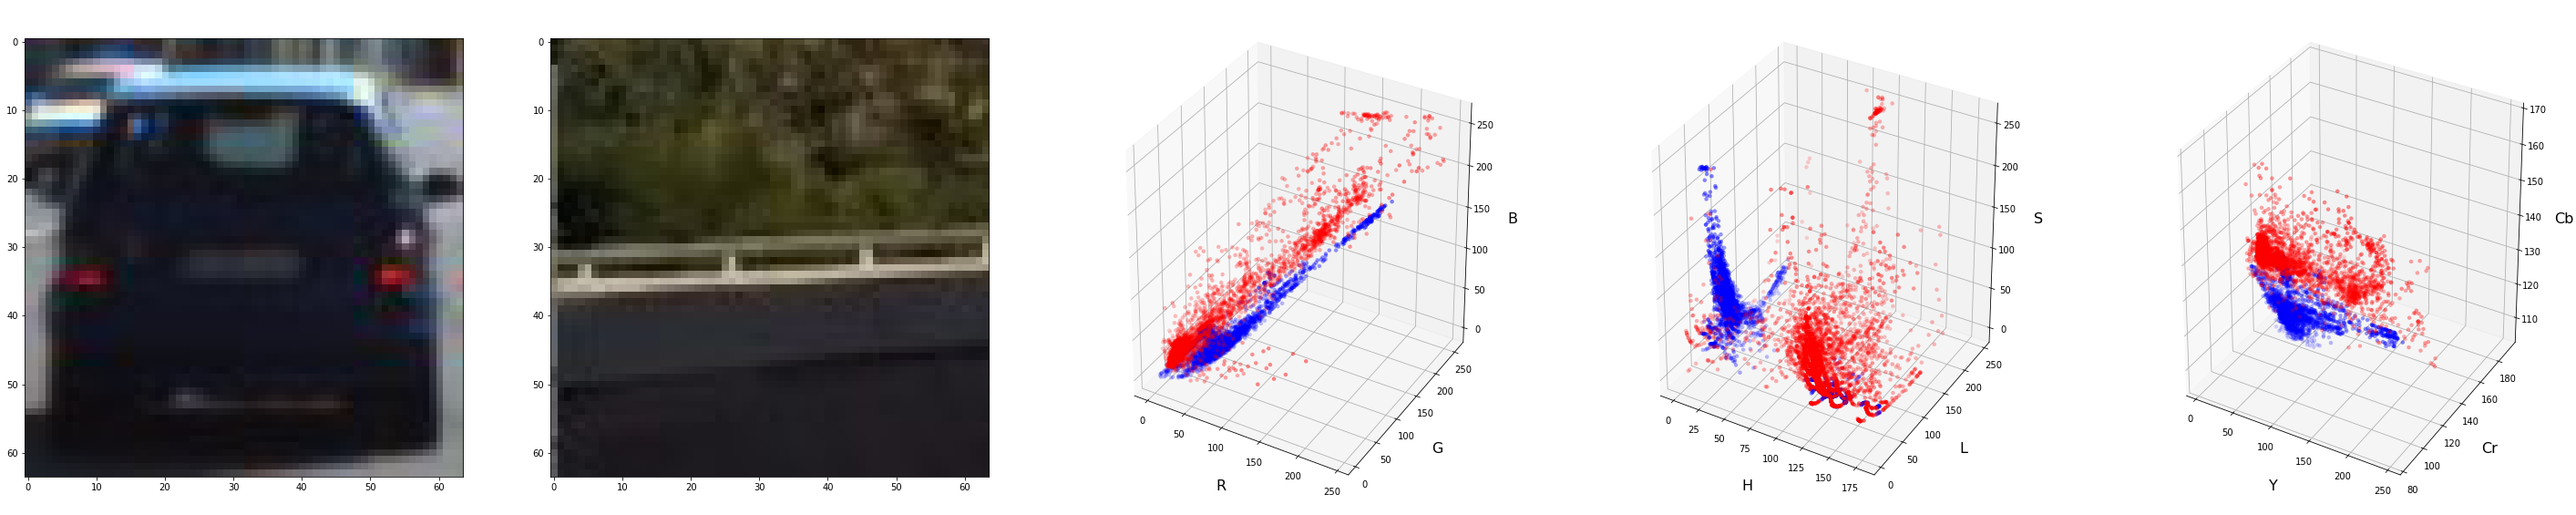

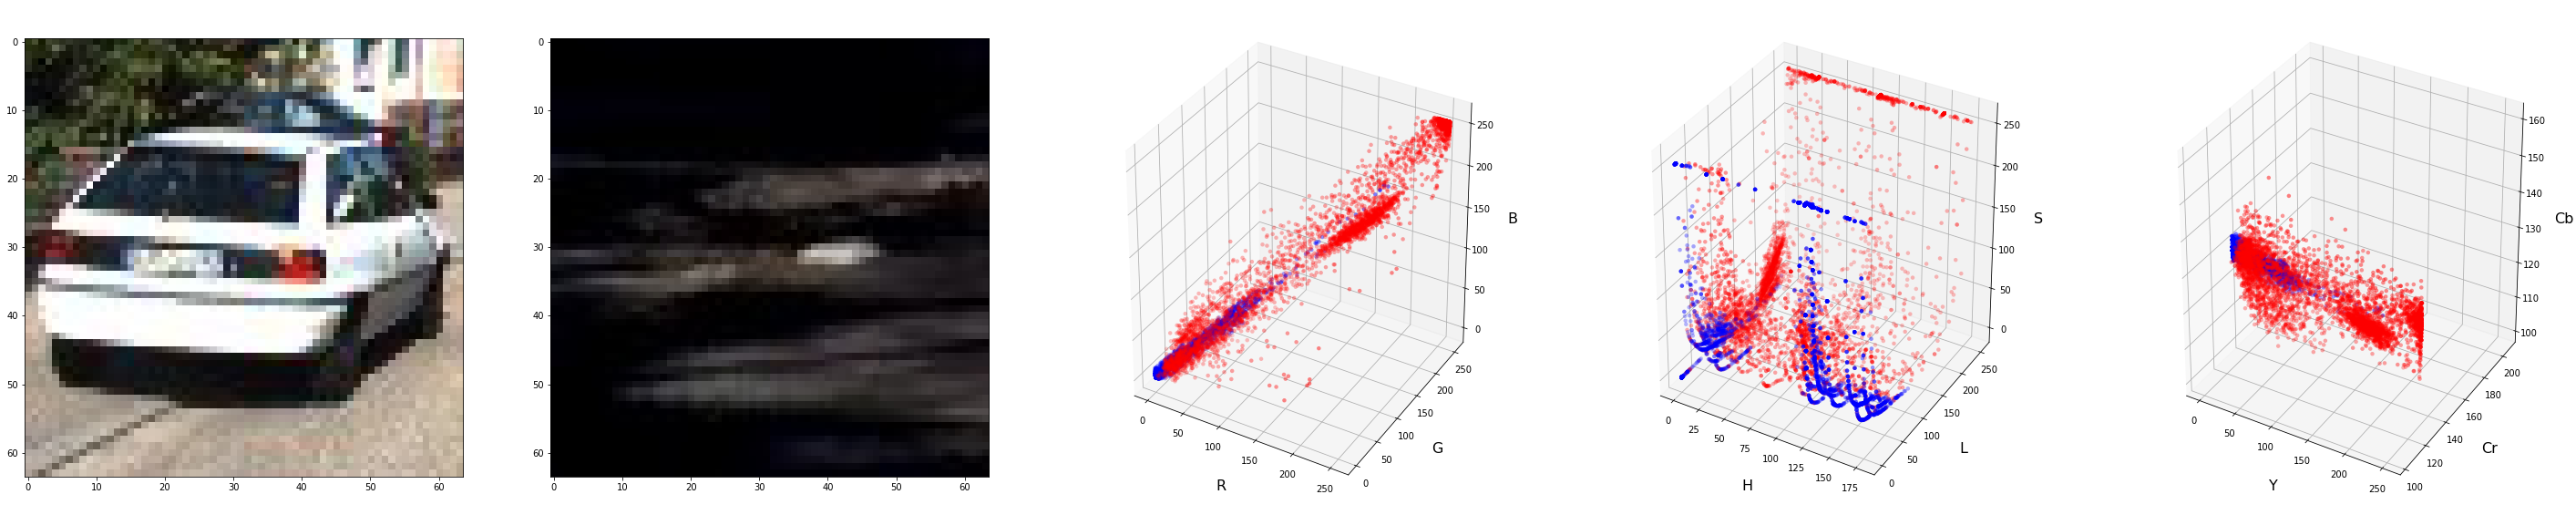

In [5]:
from mpl_toolkits.mplot3d import Axes3D

### Take 5 car and non-car images 
cars = random.sample(car_images,5)
not_cars = random.sample(not_car_images,5)


### get a set of [RGB, HLS, YCrCb] color spaces for image
def scaled_color_spaces(img):
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_RGB2HLS)
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_RGB2YCrCb)
    
    return [img_small,img_small_HLS, img_small_YCrCb]
    

### plot their pixel values in different color spaces
for i in range(0,len(cars)):
    
    car = cars[i]
    not_car = not_cars[i]
    
    car_color_spaces = scaled_color_spaces(car)
    not_car_color_spaces = scaled_color_spaces(not_car)

    fig = plt.figure(figsize=(50,10))
    ax = fig.add_subplot(151)
    ax.imshow(car)
    ax = fig.add_subplot(152)
    ax.imshow(not_car)

    axis_labels = [["R","G","B"], ["H","L","S"] ,["Y","Cr","Cb"]]
    for i in range(0,len(car_color_spaces)):
        car_pixels = car_color_spaces[i]
        not_car_pixels = not_car_color_spaces[i]
        ax = fig.add_subplot(1,5,i+3, projection='3d')
        
        ax.set_xlabel(axis_labels[i][0], fontsize=16, labelpad=16)
        ax.set_ylabel(axis_labels[i][1], fontsize=16, labelpad=16)
        ax.set_zlabel(axis_labels[i][2], fontsize=16, labelpad=16)

        ax.scatter(
        car_pixels[:, :, 0].ravel(),
        car_pixels[:, :, 1].ravel(),
        car_pixels[:, :, 2].ravel(),
        c= np.asarray([1,0,0,0.5]), edgecolors='none')
        ax.scatter(
        not_car_pixels[:, :, 0].ravel(),
        not_car_pixels[:, :, 1].ravel(),
        not_car_pixels[:, :, 2].ravel(),
        c= np.asarray([0,0,1,0.5]), edgecolors='none')
    

    # Plot and show
    plt.show()


In [6]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the YcrCb channels separately
    yhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    crhist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    cbhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = yhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((yhist[0], crhist[0], cbhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return yhist, crhist, cbhist, bin_centers, hist_features


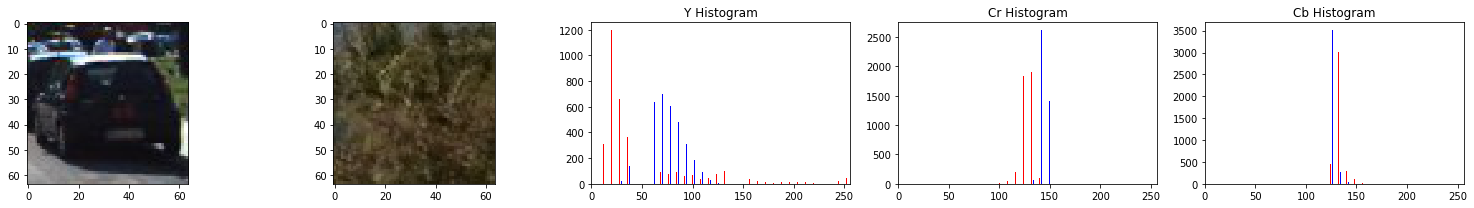

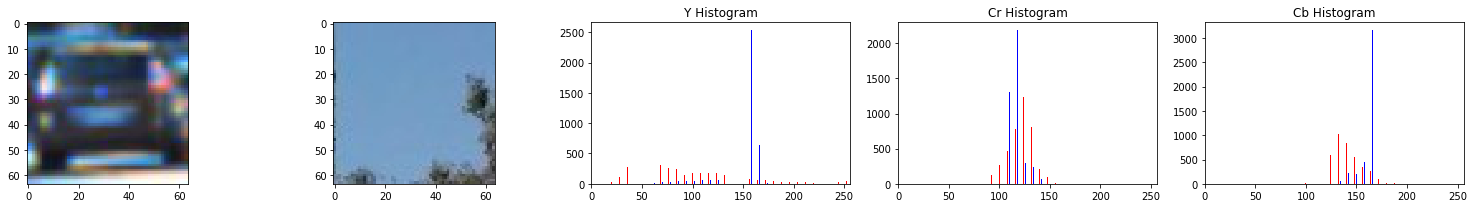

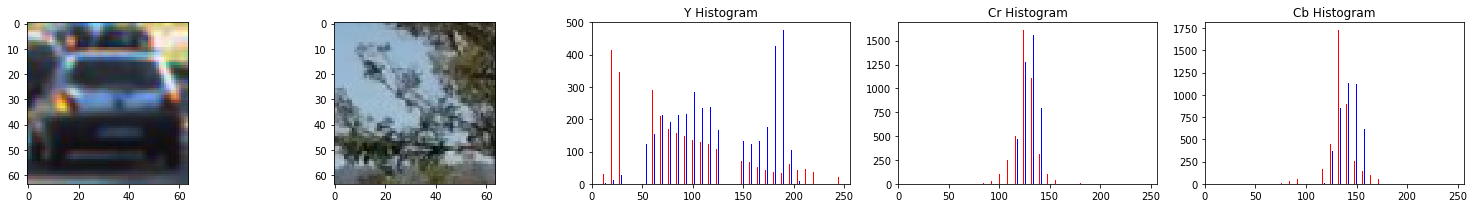

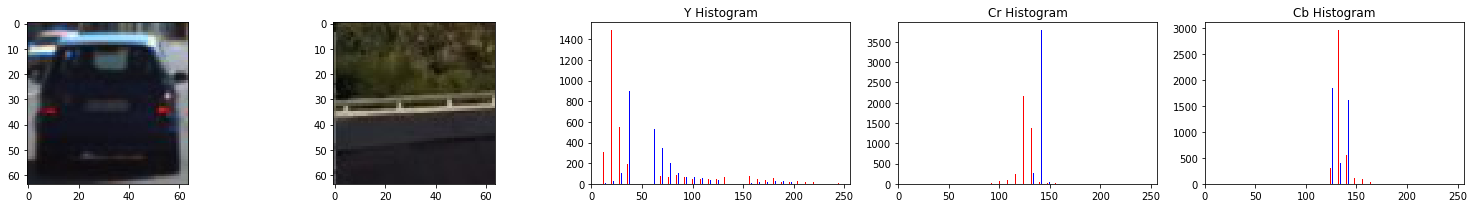

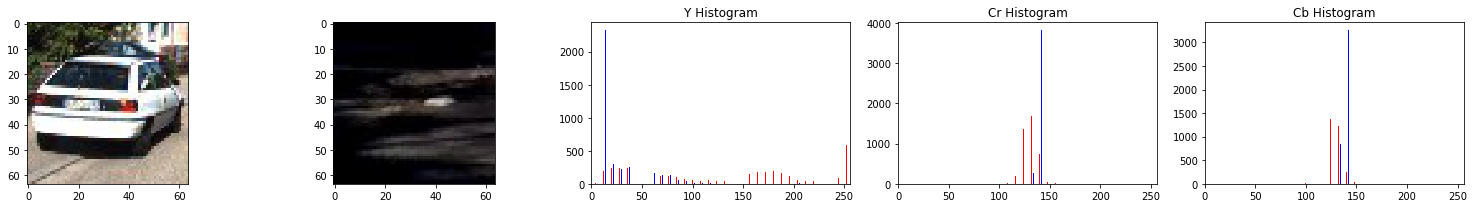

In [7]:
# Plot Each channel histogram for car and non car

for i in range(0,len(cars)):
    car = cars[i]
    not_car = not_cars[i]
    
    yh, crh, cbh, bincen, feature_vec = color_hist(cv2.cvtColor(car, cv2.COLOR_RGB2YCrCb), nbins=32, bins_range=(0, 256))
    nyh, ncrh, ncbh, nbincen, nfeature_vec = color_hist(cv2.cvtColor(not_car, cv2.COLOR_RGB2YCrCb), nbins=32, bins_range=(0, 256))
    fig = plt.figure(figsize=(21,3))
    ax = plt.subplot(151)
    ax.imshow(car)
    ax = plt.subplot(152)
    ax.imshow(not_car)
    plt.subplot(153)
    plt.bar(bincen, yh[0], color = [1,0,0])
    plt.bar(bincen + 10, nyh[0], color=[0,0,1])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(154)
    plt.bar(bincen, crh[0], color = "r")
    plt.bar(bincen + 10, ncrh[0], color = "b")
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(155)
    plt.bar(bincen, cbh[0], color = 'r')
    plt.bar(bincen + 10 , ncbh[0], color = "b")
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    plt.show()
        

#### 1. c. Feature extraction - Spatial

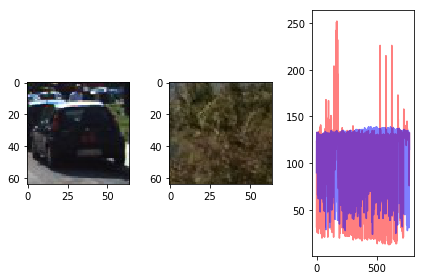

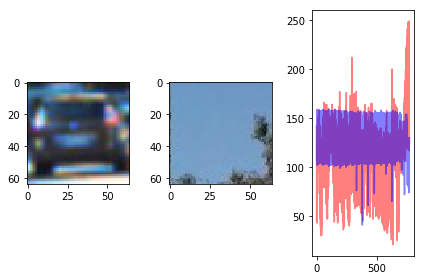

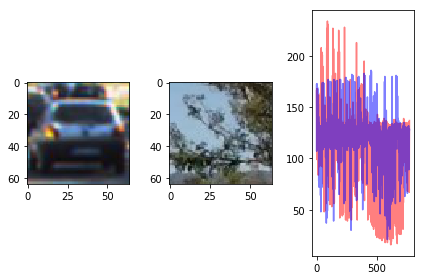

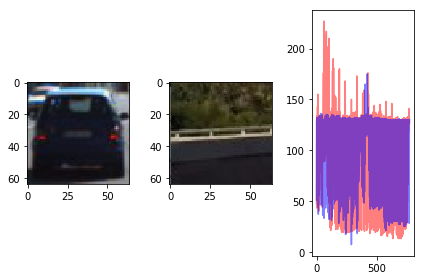

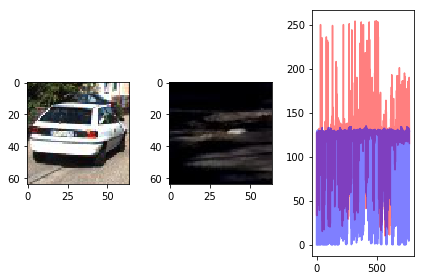

In [8]:
import features

for i in range(0,5):
    car = cv2.cvtColor(cars[i],cv2.COLOR_RGB2YCrCb)
    not_car = cv2.cvtColor(not_cars[i],cv2.COLOR_RGB2YCrCb)
    car_spatial = bin_spatial(car)
    not_car_spatial = bin_spatial(not_car)
    ax = plt.subplot(131)
    ax.imshow(cars[i])
    ax = plt.subplot(132)
    ax.imshow(not_cars[i])
    plt.subplot(133)
    plt.plot(car_spatial, color = [1,0,0, 0.5])
    plt.plot(not_car_spatial, color = [0,0,1, 0.5])
    plt.tight_layout()
    plt.show()


### 2. Training a classifier

#### 2. a. Training a classifier - Building the data set

In [9]:
cars = []
notcars = []
notcars_files = glob('data/non-vehicles/*/*.png')
cars_files = glob('data/vehicles/*/*.png')

#### 2. b. Training a classifier - Extracting Features

In [10]:
car_features = []
notcar_features = []
for file in cars_files:
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    feature = full_feature(im)
    car_features.append(feature)
for file in notcars_files:
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    feature = full_feature(im)
    notcar_features.append(feature)
    
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#### 2. c. Training a classifier - Scaling Features

In [11]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

#### 2. d. Training a classifier - Training SVM

In [12]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('Accuracy =', accuracy)


Accuracy = 0.9938


### 3. Window search

#### 3. a. Window Search - Positive detections

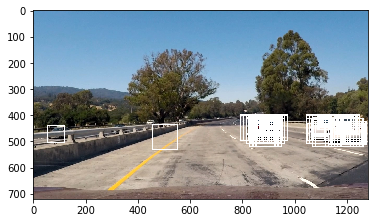

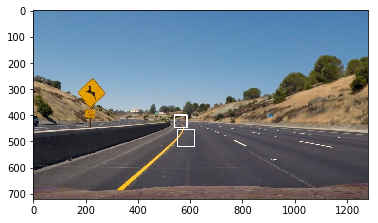

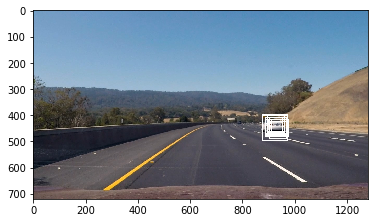

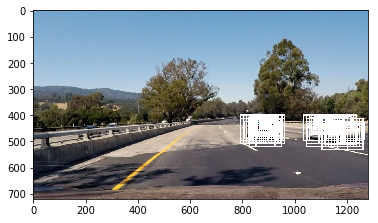

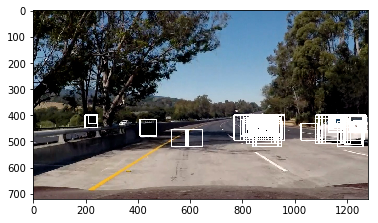

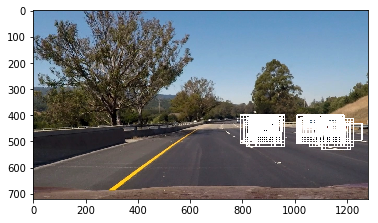

In [13]:
clf = SVCClassifier(svc,X_scaler)
vd = VehicleDetector(clf)

for file in glob("sample_data/test_images/*.jpg"):
    image = cv2.imread(file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    positive_detections = vd.detections(image)
    draw_img = draw_boxes(image,positive_detections, [255,255,255], 4)
    plt.imshow(draw_img)
    plt.show()


### 4. Bounding Boxes

 #### 4. a. Bounding Boxes - Multiple detctions and false positives (heat map)

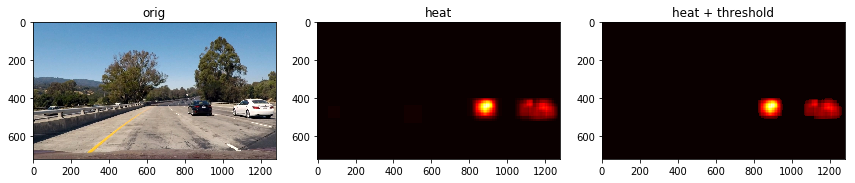

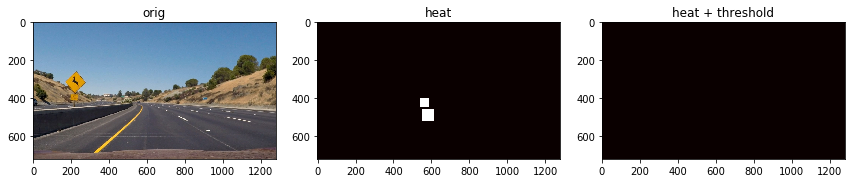

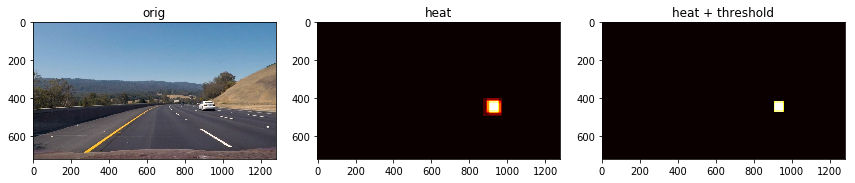

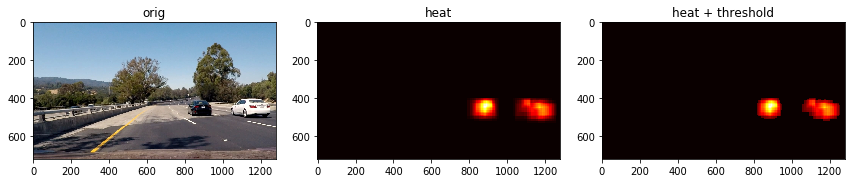

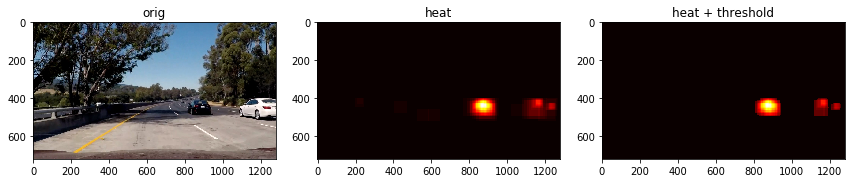

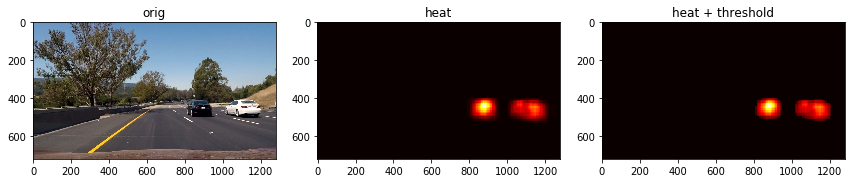

In [23]:
clf = SVCClassifier(svc,X_scaler)
vd = VehicleDetector(clf)

for file in glob("sample_data/test_images/*.jpg"):
    image = cv2.imread(file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    positive_detections = vd.detections(image)
    hot_windows = vd.detections(image)
    heat = heatmap(image.shape[:2],hot_windows)
    threshold = 6
    thresh_heat = apply_threshold(heat,threshold)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('orig')
    
    ax2.imshow(heat, cmap = 'hot')
    ax2.set_title('heat')
    
    ax3.imshow(thresh_heat, cmap = 'hot')
    ax3.set_title('heat + threshold')


 #### 4. b. Bounding Boxes - bounding boxes from heat map

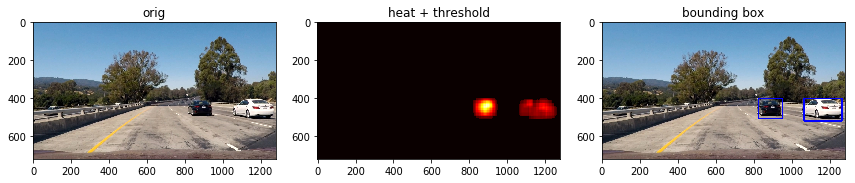

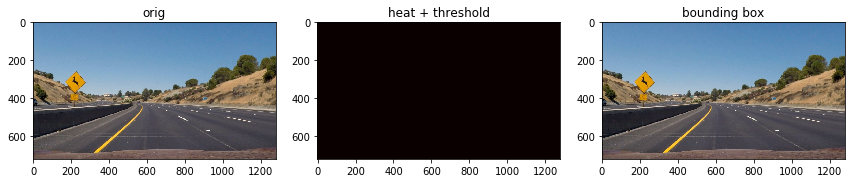

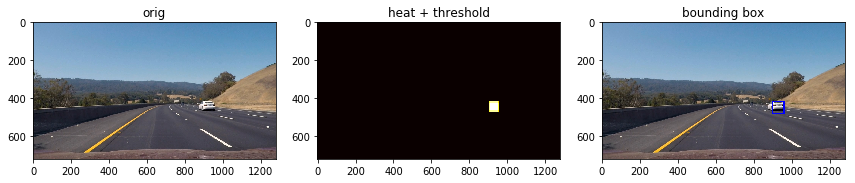

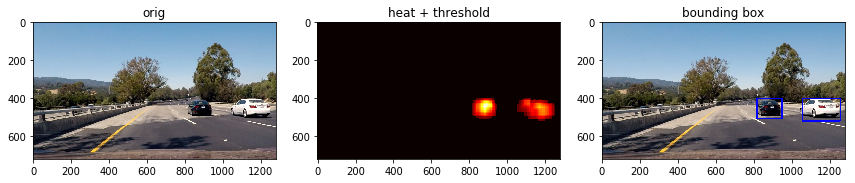

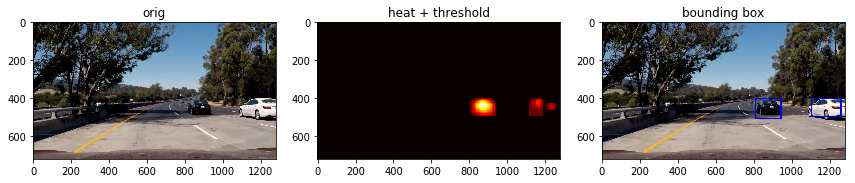

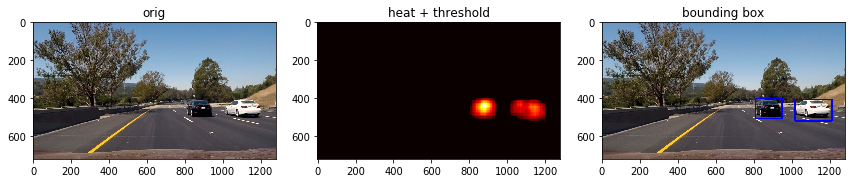

In [25]:
for file in glob("sample_data/test_images/*.jpg"):
    image = cv2.imread(file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    positive_detections = vd.detections(image)
    hot_windows = vd.detections(image)
    heat = heatmap(image.shape[:2],hot_windows)
    threshold = 6
    thresh_heat = apply_threshold(heat,threshold)
    bboxes = vd.detect_vehicles(image)
    draw_img = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('orig')
    
    ax2.imshow(thresh_heat, cmap = 'hot')
    ax2.set_title('heat + threshold')
    
    ax3.imshow(draw_img)
    ax3.set_title('bounding box')



### 5. Video

#### 5. a. Video - processing single frame for bounding boxes

In [16]:
clf = SVCClassifier(svc,X_scaler)
vd = VehicleDetector(clf)

def process_frame(img):
    bboxes = vd.detect_vehicles(img)
    draw_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
    return draw_img


In [26]:
single_frame_output_path = ("output_images/project_video-test-single-frames.mp4")
video = VideoFileClip("data/project_video.mp4").subclip(39,42)
video_output = video.fl_image(process_frame)
%time video_output.write_videofile(single_frame_output_path, audio=False)


[MoviePy] >>>> Building video project_video-test-single-frames.mp4
[MoviePy] Writing video project_video-test-single-frames.mp4


 99%|█████████▊| 75/76 [04:17<00:03,  3.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video-test-single-frames.mp4 

CPU times: user 4min 21s, sys: 340 ms, total: 4min 21s
Wall time: 4min 18s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(single_frame_output_path))
 

#### 5. b. Video - processing multiple frames

In [19]:

clf = SVCClassifier(svc,X_scaler)
vd = VehicleDetector(clf)

history = deque(maxlen=10)

def multi_frame_process(img):
    bboxes = vd.detect_vehicles(img)
    history.append(bboxes)
    hot_windows = [item for sublist in history for item in sublist]

    heat = heatmap(img.shape[:2],hot_windows)

    threshold = min(len(history),6)
    thresh_heat = apply_threshold(heat,threshold)

    new = bounding_boxes(thresh_heat)

    draw_img = draw_boxes(img, new, color=(0, 0, 255), thick=6)

    return draw_img


In [20]:
multi_frame_output_path = ("output_images/project_video-test-multi-frame.mp4")
video = VideoFileClip("data/project_video.mp4").subclip(39,42)
video_output = video.fl_image(multi_frame_process)
%time video_output.write_videofile(multi_frame_output_path, audio=False)


[MoviePy] >>>> Building video project_video-test-multi-frame.mp4
[MoviePy] Writing video project_video-test-multi-frame.mp4


 99%|█████████▊| 75/76 [04:05<00:03,  3.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video-test-multi-frame.mp4 

CPU times: user 4min 9s, sys: 380 ms, total: 4min 10s
Wall time: 4min 6s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(multi_frame_output_path))
